Starting Radar Chart Generation (Female Characters)...

Processing Radar Chart for The Fellowship of the Ring...


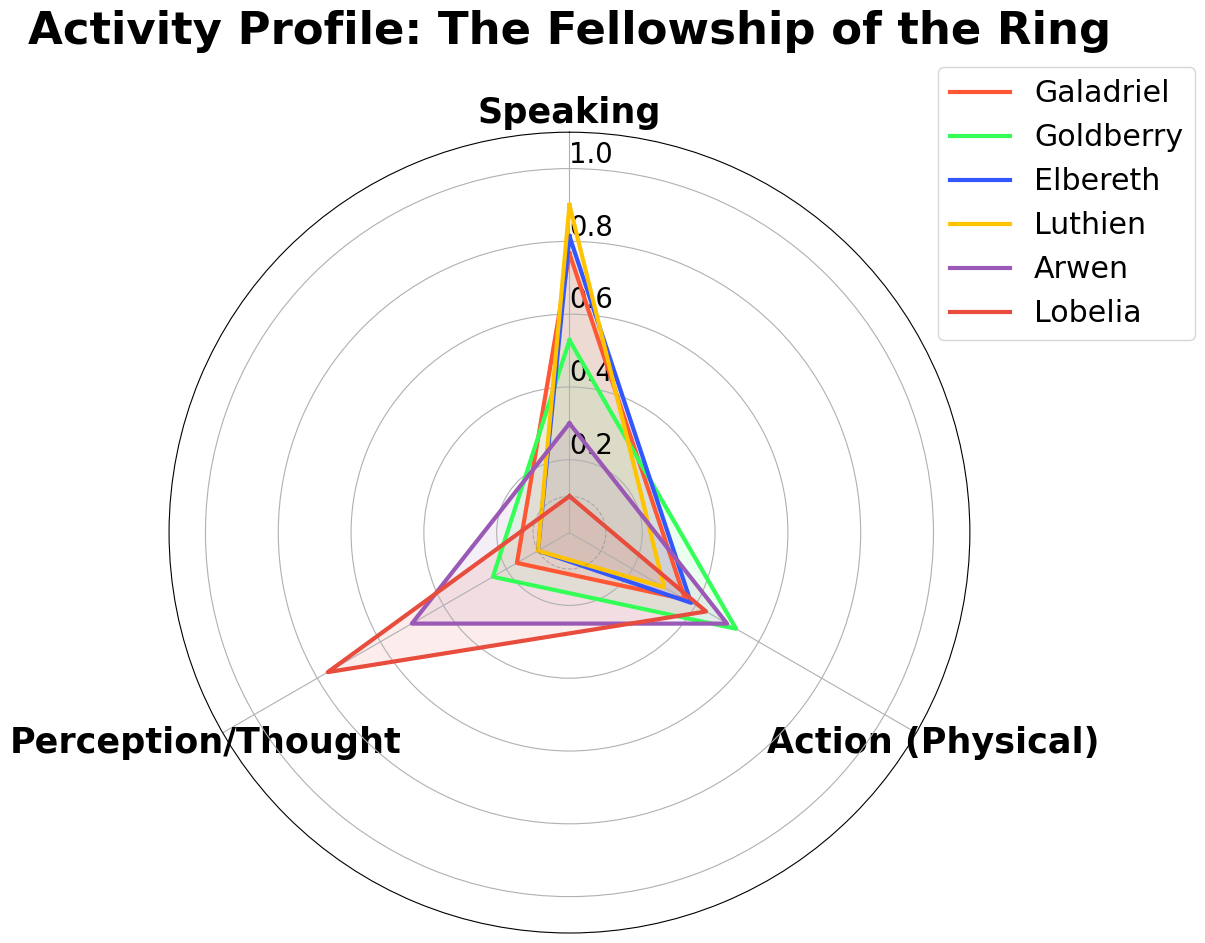


Processing Radar Chart for The Two Towers...
Found Eowyn variants in text (before lowercase): {'Éowyn'}
Found Eowyn variants after lowercase: {'éowyn'}


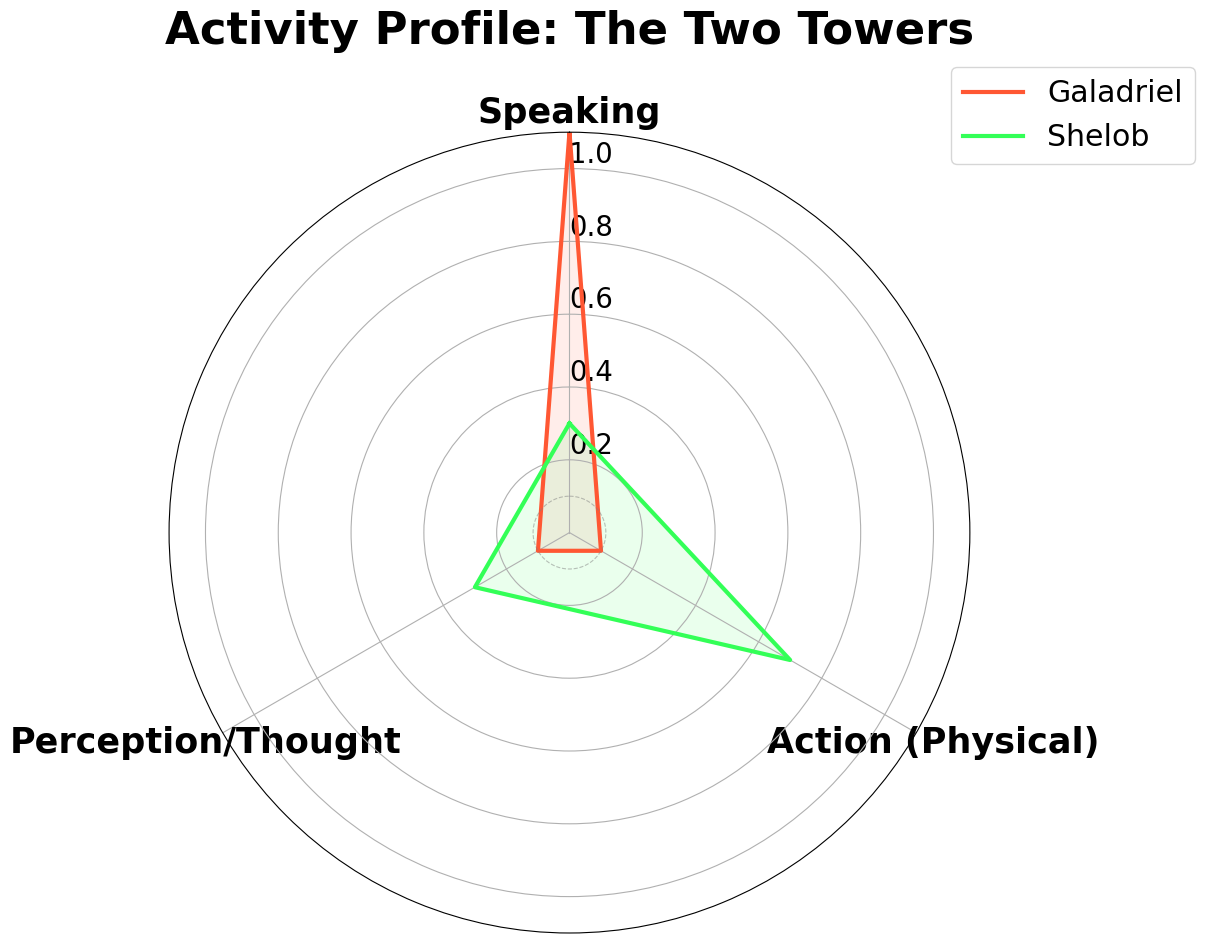


Processing Radar Chart for The Return of the King...
Found Eowyn variants in text (before lowercase): {'Éowyn'}
Found Eowyn variants after lowercase: {'éowyn'}


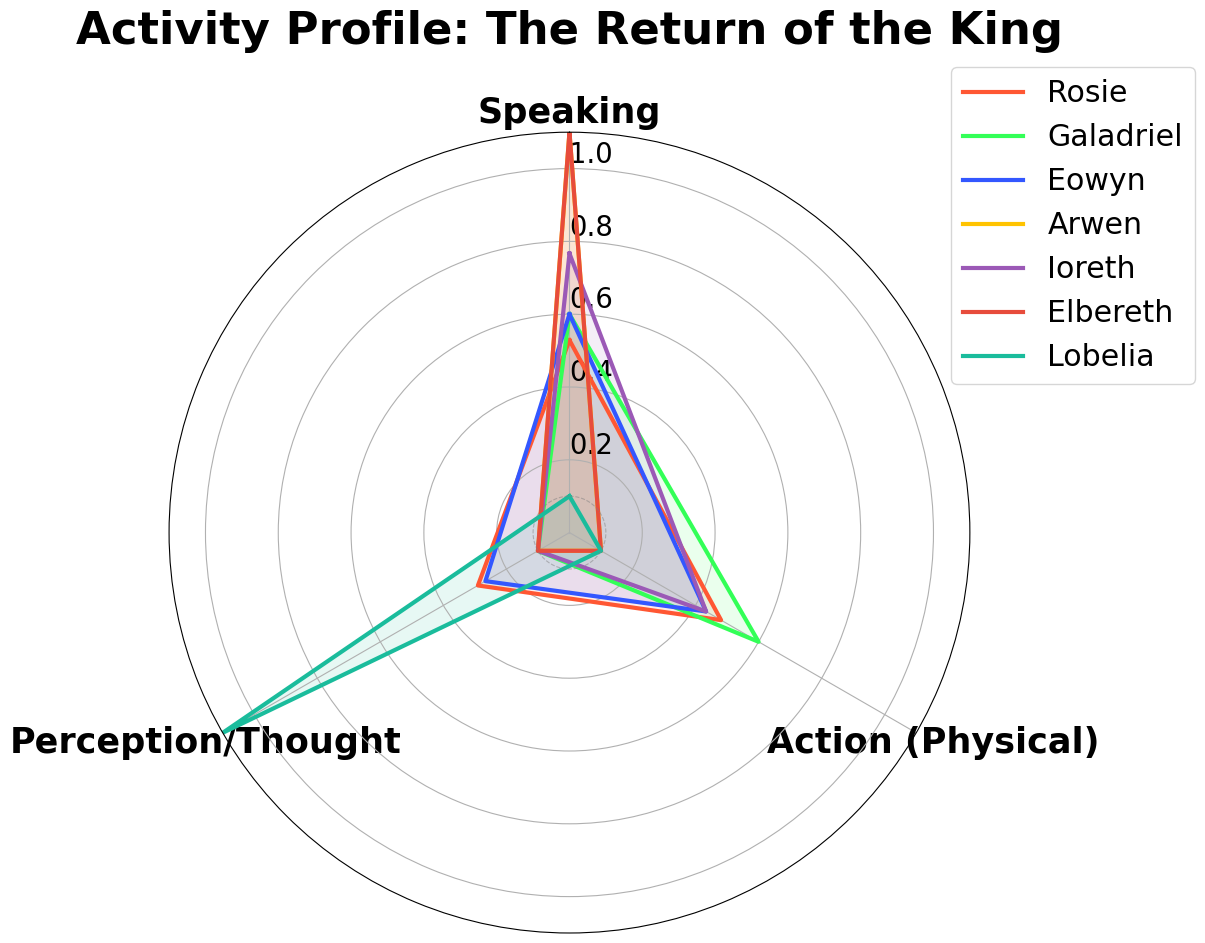

In [4]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
# (Duplicated config for standalone execution if needed, but ideally imported or passed)
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING ---
FEMALE_CHARACTERS_COMPREHENSIVE = {
    # Major Active
    "Galadriel": ["galadriel", "lady of light", "lady of the wood", "sorceress of the golden wood", "lady of lorien", "white lady"],
    "Eowyn": ["eowyn", "éowyn", "damsel", "shieldmaiden", "dernhelm", "sister-daughter", "lady of rohan", "white lady of rohan"],
    "Arwen": ["arwen", "undomiel", "evenstar", "daughter of elrond", "queen"],
    "Shelob": ["shelob", "spider", "her ladyship"],
    "Goldberry": ["goldberry", "river-daughter", "river-woman's daughter"],

    # Minor / Supporting / Historical / Deities
    "Rosie": ["rosie", "rose", "rosie-lass"], #"cotton"
    "Ioreth": ["ioreth", "wise-woman", "old wife", "Ioreth"],
    "Lobelia": ["lobelia", "sackville-baggins"],
    "Primula": ["primula"],
    "Belladonna": ["belladonna"],
    "Gilraen": ["gilraen"],
    "Luthien": ["luthien", "tinuviel", "nightingale"],
    "Elbereth": ["elbereth", "gilthoniel", "varda", "star-kindler"],
}

# --- BOOK FILTERS ---
BOOK_FILTERS = {
    "The Fellowship of the Ring": ["Galadriel", "Goldberry", "Arwen", "Lobelia", "Luthien", "Elbereth", "Gilraen"],
    "The Two Towers": ["Eowyn", "Shelob", "Galadriel", "Arwen", "Elbereth", "Luthien"],
    "The Return of the King": ["Eowyn", "Arwen", "Rosie", "Ioreth", "Lobelia", "Galadriel", "Elbereth", "Luthien"],
}

# --- EXPANDED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set(["said", "asked", "replied", "answered", "cried", "shouted", "whispered",
                     "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
                     "commanded", "demanded", "begged", "warned", "laughed", "sighed",
                     "continued", "added", "explained", "agreed", "announced", "greeting", "wept"]),
    "Action (Physical)": set(["ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell",
                              "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held",
                              "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat",
                              "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed",
                              "went", "came", "gave", "took", "put", "set", "lay", "waited", "passed", "crawled", "stung", "bit"]),
    "Perception/Thought": set(["saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched",
                               "noticed", "listened", "wondered", "remembered", "feared", "hoped",
                               "stared", "glanced", "gazed", "perceived", "understood", "believed",
                               "realized", "guessed", "loved", "wished"])
}

SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again", "and", "but", "so", "very"])

# --- DATA LOADING AND ANALYSIS (Copied for standalone functionality) ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
    clean_text = text[start_idx:end_idx]
    
    # DEBUG: Print sample of Eowyn mentions BEFORE lowercasing
    import re as re_debug
    eowyn_matches = re_debug.findall(r'\b\w*[eéEÉ][oóOÓ]wyn\w*\b', clean_text, re_debug.IGNORECASE)
    if eowyn_matches:
        print(f"Found Eowyn variants in text (before lowercase): {set(eowyn_matches[:20])}")
    
    clean_text = clean_text.lower()
    
    # Check again after lowercasing
    eowyn_matches_lower = re_debug.findall(r'\b\w*[eéEÉ][oóOÓ]wyn\w*\b', clean_text, re_debug.IGNORECASE)
    if eowyn_matches_lower:
        print(f"Found Eowyn variants after lowercase: {set(eowyn_matches_lower[:20])}")
    
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

def analyze_activity(tokens, alias_map, window_after=6):
    activity_stats = defaultdict(lambda: defaultdict(int))
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: continue
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break
                if found_verb: break
    return activity_stats


# --- RADAR CHART FUNCTION (Per Book) - ALL CHARACTERS VERSION ---
def plot_book_radar_profiles(stats, title, text_scaling=1.5, fig_size_scale=1.2):
    """
    Plots a radar chart for ALL active characters in a specific book.
    Args:
        stats: Activity stats dictionary for the book.
        title: Title of the book.
        text_scaling: Multiplier for font sizes.
        fig_size_scale: Multiplier for figure size.
    """
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 0}
    if not active_chars:
        print(f"No active characters to plot for {title}")
        return

    # Calculate Font Sizes based on scaling
    title_fs = 18 * text_scaling
    label_fs = 14 * text_scaling
    tick_fs = 11 * text_scaling
    legend_fs = 12 * text_scaling

    # ALL active characters (sorted by total activity for consistent ordering)
    all_chars = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]

    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Calculate Figure Size
    fig, ax = plt.subplots(figsize=(8 * fig_size_scale, 8 * fig_size_scale), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, size=label_fs, fontweight='bold')
    ax.set_rlabel_position(0)
    plt.yticks(fontsize=tick_fs)
    
    # Set y-axis limit to accommodate the offset
    ax.set_ylim(0, 1.1) 

    colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#9B59B6', '#E74C3C', '#1ABC9C', '#F39C12', '#8E44AD', '#2ECC71', '#E67E22', '#3498DB', '#C0392B']
    
    # DEAD ZONE OFFSET
    dead_zone = 0.1

    for i, char in enumerate(all_chars):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]

        total = sum(values) if sum(values) > 0 else 1
        # Normalize and then ADD DEAD ZONE offset
        norm_values = [(v/total) + dead_zone for v in values]
        norm_values += norm_values[:1]

        color = colors[i % len(colors)]

        ax.plot(angles, norm_values, linewidth=3, linestyle='solid', label=char, color=color)
        ax.fill(angles, norm_values, color=color, alpha=0.1)
        
    # Add a circle to indicate the dead zone
    grid_angles = np.linspace(0, 2*pi, 100)
    ax.plot(grid_angles, [dead_zone]*100, color='grey', linestyle='--', linewidth=0.8, alpha=0.5)

    plt.title(f"Activity Profile: {title}", size=title_fs, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=legend_fs)
    plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    books = [
        ("The Fellowship of the Ring", CONFIG["book1_path"]),
        ("The Two Towers", CONFIG["book2_path"]),
        ("The Return of the King", CONFIG["book3_path"])
    ]

    print("Starting Radar Chart Generation (Female Characters)...")

    for title, path in books:
        print(f"\nProcessing Radar Chart for {title}...")
        relevant_names = BOOK_FILTERS.get(title, [])

        book_alias_map = {}
        for name in relevant_names:
            for alias in FEMALE_CHARACTERS_COMPREHENSIVE.get(name, []):
                book_alias_map[alias] = name

        tokens = clean_and_tokenize(path)

        if tokens:
            act_stats = analyze_activity(tokens, book_alias_map, window_after=6)
            
            # Generate Radar Chart for THIS book - ALL CHARACTERS
            # ADJUST SIZES HERE: text_scaling=1.5 (bigger text), fig_size_scale=1.2 (bigger image)
            plot_book_radar_profiles(act_stats, title, text_scaling=1.8, fig_size_scale=1.3)

        else:
            print(f"Error: No tokens found for {title}.")

Starting Enhanced Activity Analysis...

Analyzing The Fellowship of the Ring...


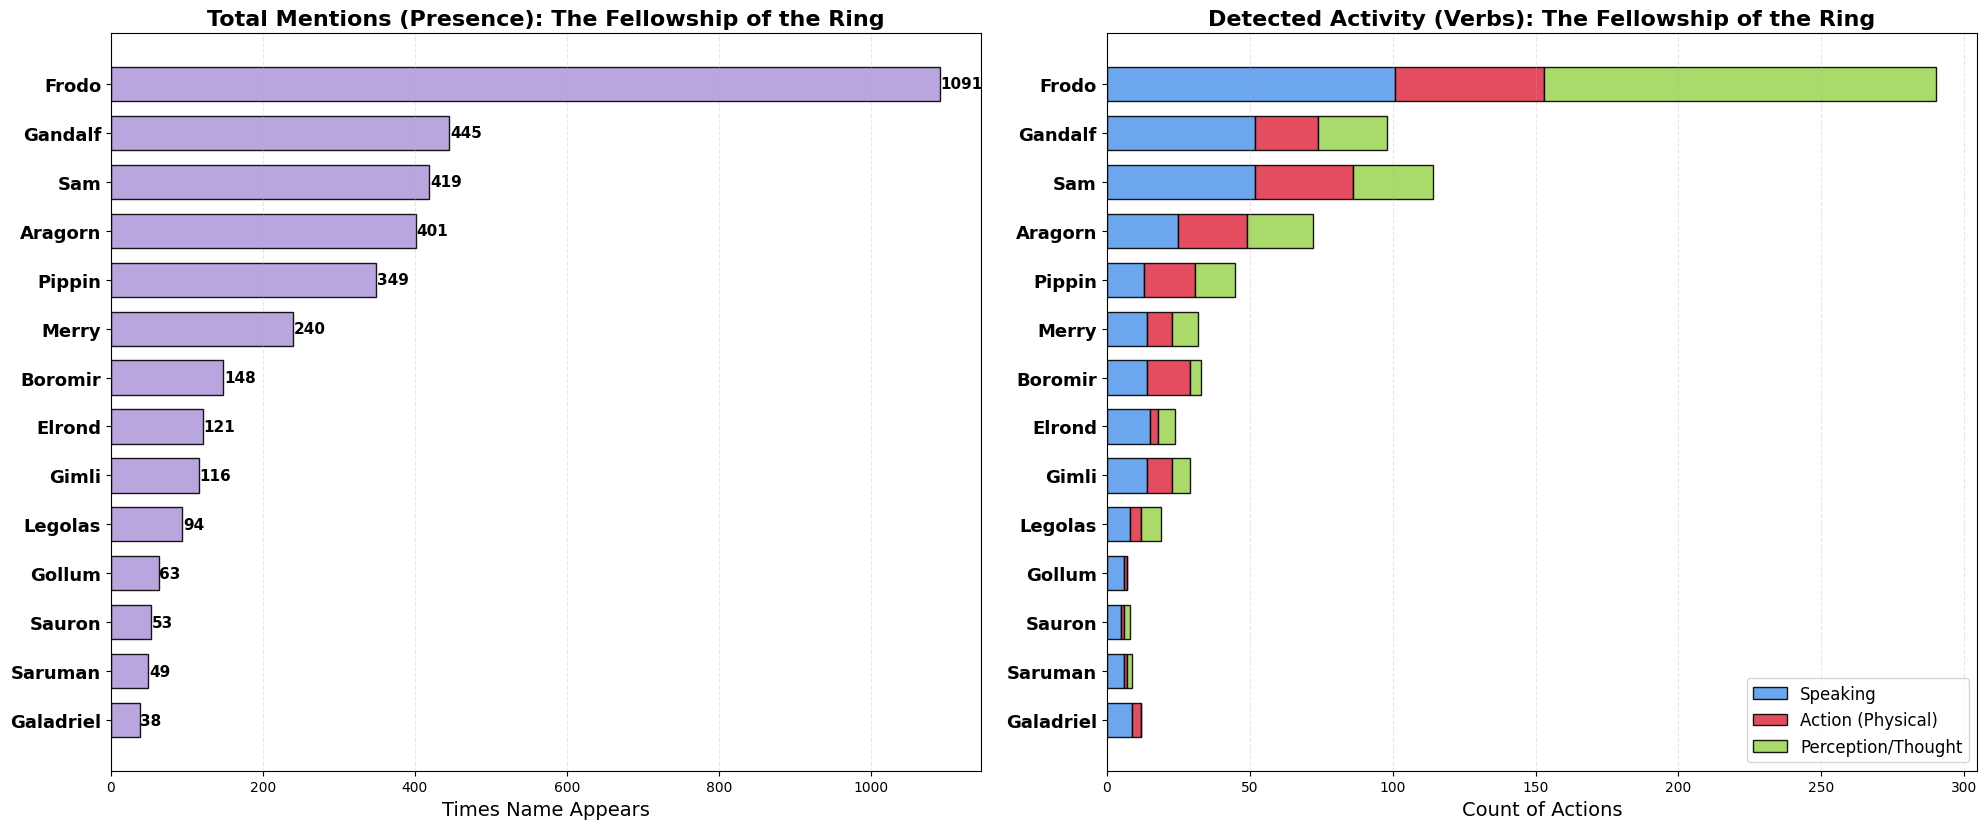

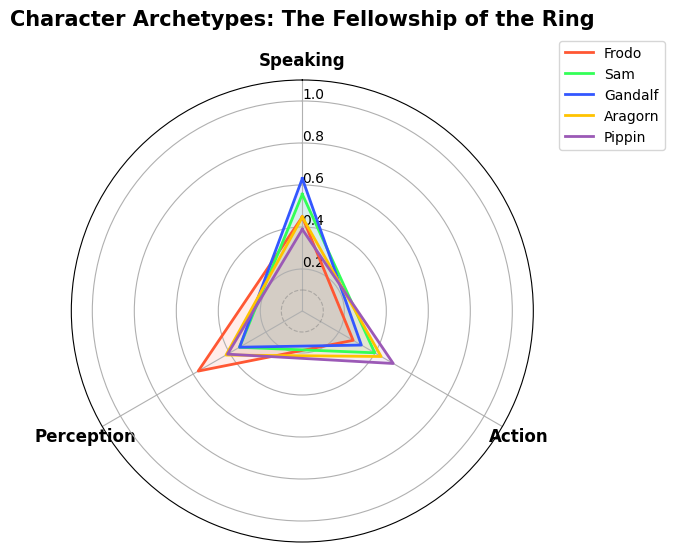


Analyzing The Two Towers...


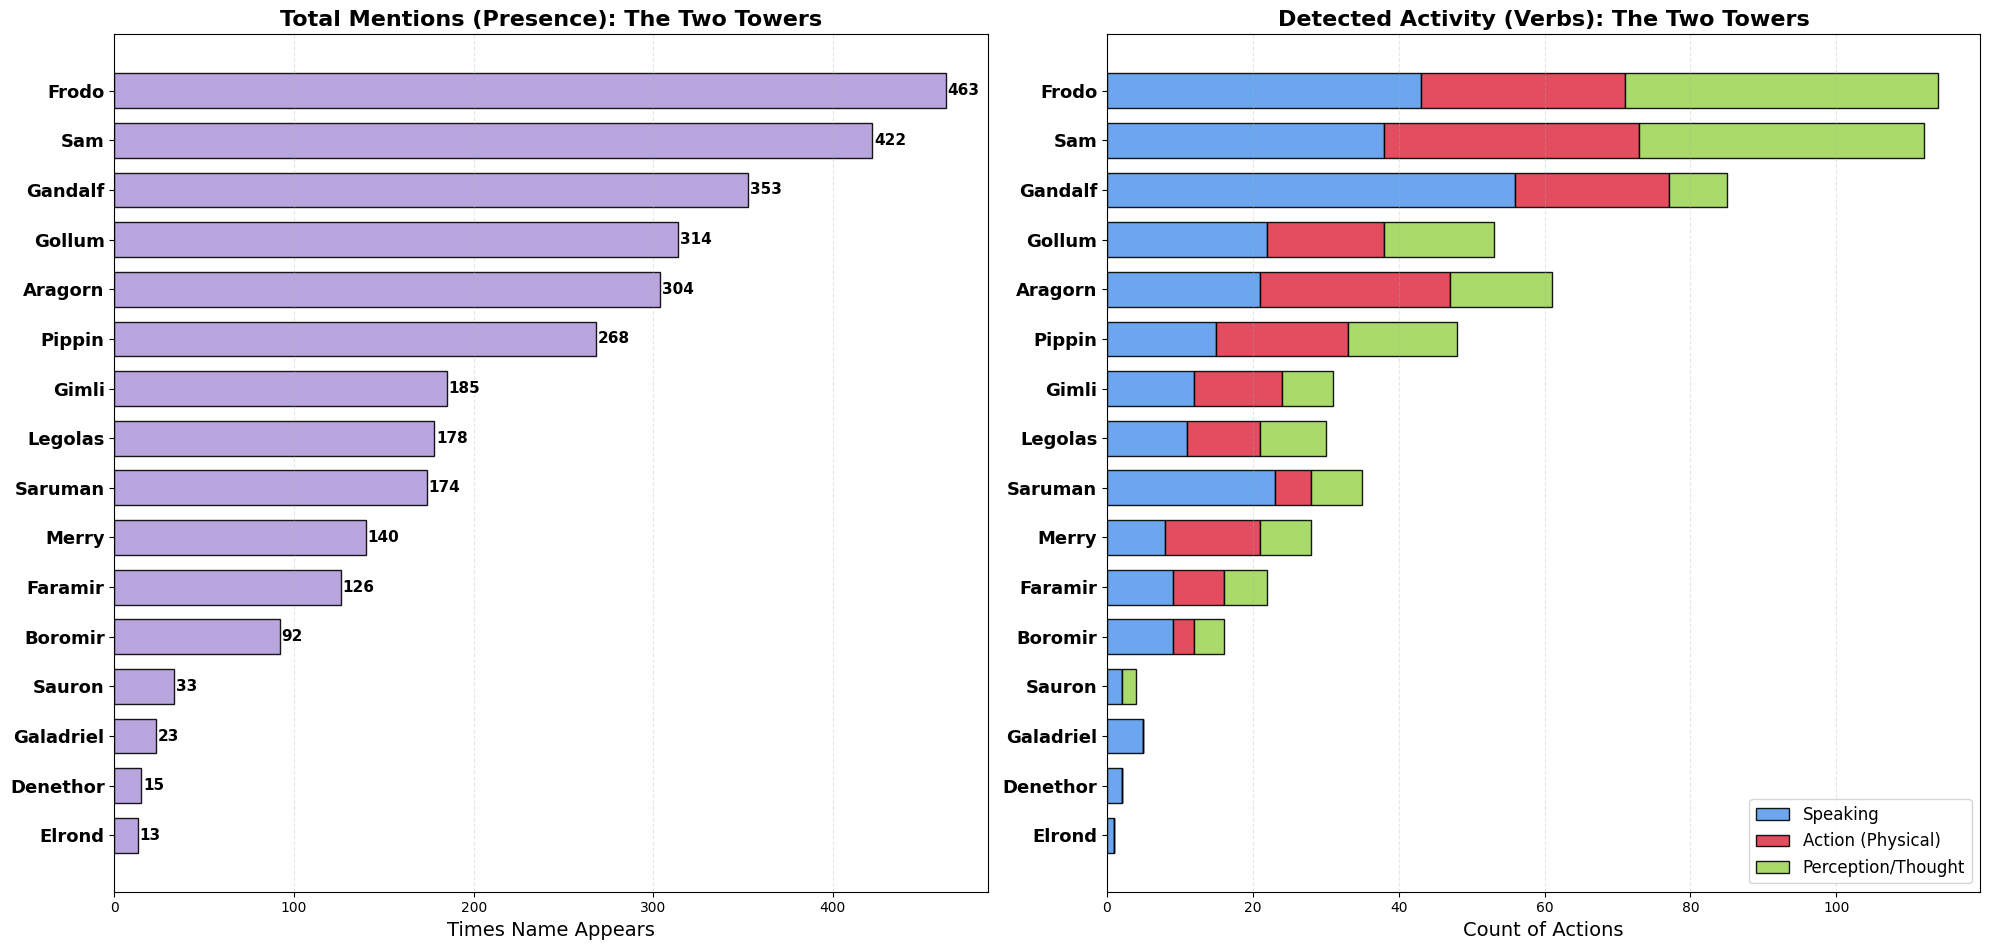

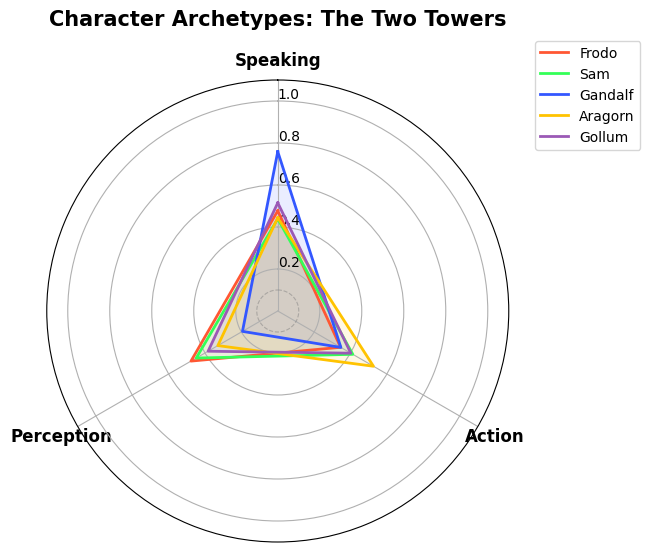


Analyzing The Return of the King...


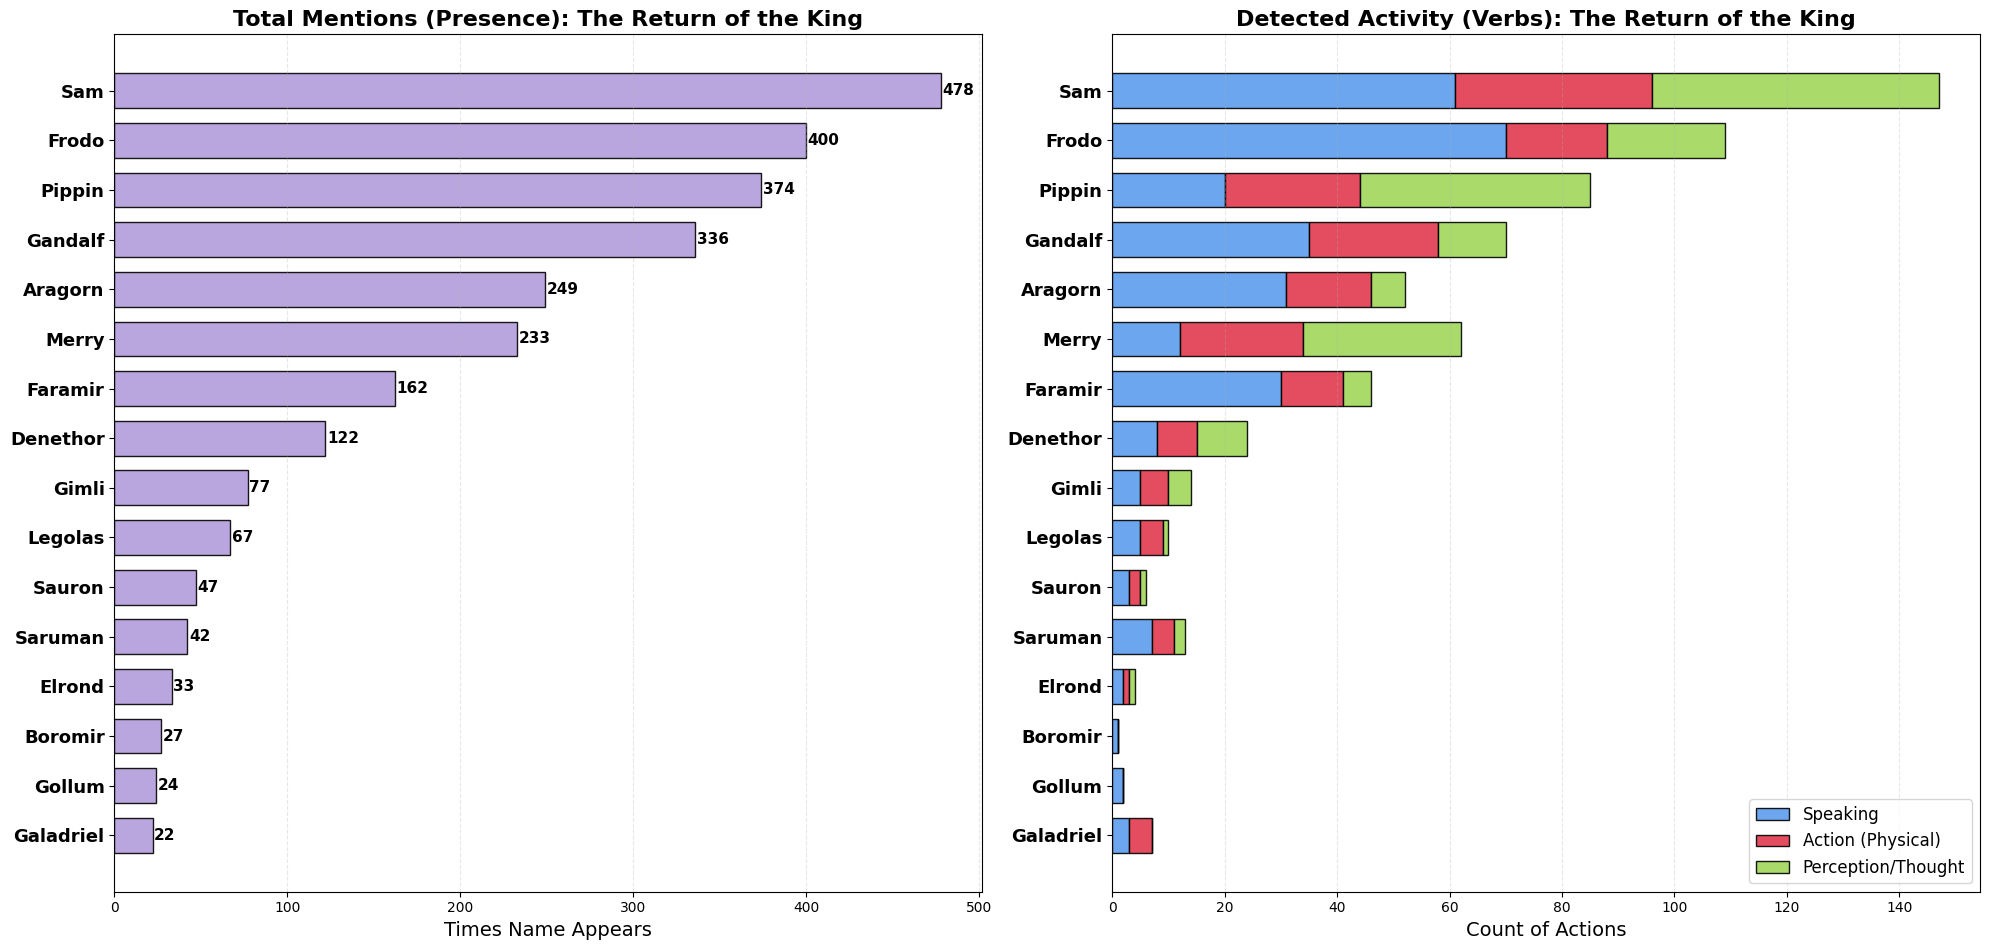

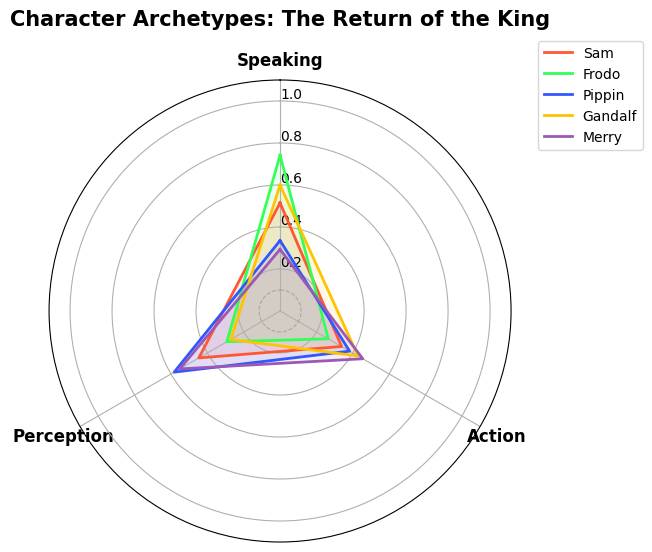

In [5]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# Character Mapping (YOUR ORIGINAL LIST)
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"]
}

# Create alias lookup
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# --- IMPROVED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set([
        "said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
        "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
        "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
        "continued", "added", "explained", "agreed", "announced"
    ]),
    "Action (Physical)": set([
        "ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
        "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
        "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
        "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed"
    ]),
    "Perception/Thought": set([
        "saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
        "noticed", "listened", "wondered", "remembered", "feared", "hoped",
        "stared", "glanced", "gazed", "perceived", "understood", "believed", 
        "realized", "guessed"
    ])
}

# Words to ignore when scanning window (adverbs, fillers)
SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    """Loads and tokenizes text."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    # Strip headers
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC (FILTER REMOVED) ---
def analyze_activity(tokens, alias_map, window_after=4):
    """
    Scans for Character + Verb patterns.
    Returns:
      1. activity_stats: Counts of verbs associated with characters.
      2. mention_stats: Total counts of character name appearances.
    """
    activity_stats = defaultdict(lambda: defaultdict(int))
    mention_stats = defaultdict(int)
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            
            # --- RAW COUNT: No filtering logic here anymore ---
            mention_stats[char_name] += 1 
            
            # Look at the next few words for verbs
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: 
                    continue
                
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb:
                    break
                    
    return activity_stats, mention_stats

# --- DUAL VISUALIZATION: SIDE-BY-SIDE GRAPHS ---
def plot_comparison(activity_stats, mention_stats, title):
    """
    Plots two charts side-by-side: 
    1. Total Mentions (Presence)
    2. Detected Activity (Verbs)
    """
    active_chars = [char for char in CHARACTERS.keys() if mention_stats[char] > 10]
    
    if not active_chars:
        print(f"Not enough data for {title}")
        return

    # Sort characters by TOTAL MENTIONS count
    sorted_chars = sorted(active_chars, key=lambda x: mention_stats[x], reverse=False)
    
    # --- PLOT SETUP ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, max(8, len(sorted_chars) * 0.6)))
    
    indices = np.arange(len(sorted_chars))
    bar_width = 0.7
    
    # --- LEFT CHART: TOTAL MENTIONS ---
    mention_values = [mention_stats[c] for c in sorted_chars]
    ax1.barh(indices, mention_values, color='#b39ddb', edgecolor='black', height=bar_width, alpha=0.9)
    ax1.set_title(f"Total Mentions (Presence): {title}", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Times Name Appears", fontsize=14)
    ax1.set_yticks(indices)
    ax1.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    # Add text labels
    for i, v in enumerate(mention_values):
        ax1.text(v + 1, i, str(v), va='center', fontsize=11, fontweight='bold')

    # --- RIGHT CHART: DETECTED ACTIVITY ---
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    colors = ['#5c9ded', '#e03a4e', '#a0d65a']
    lefts = np.zeros(len(sorted_chars))
    
    for i, cat in enumerate(categories):
        values = np.array([activity_stats[c][cat] for c in sorted_chars])
        ax2.barh(indices, values, left=lefts, label=cat, height=bar_width, color=colors[i], edgecolor='black', alpha=0.9)
        lefts += values
        
    ax2.set_title(f"Detected Activity (Verbs): {title}", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Count of Actions", fontsize=14)
    ax2.set_yticks(indices) 
    ax2.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=12)
    ax2.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- VISUALIZATION 2: Radar Charts WITH DEAD ZONE ---
def plot_radar_profiles(stats, title):
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 15}
    if not active_chars: return

    top_5 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:5]
    categories = ["Speaking", "Action", "Perception"]
    
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] 
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, size=12, fontweight='bold')
    ax.set_rlabel_position(0)
    
    # Set y-axis limit to accommodate the offset
    ax.set_ylim(0, 1.1)
    
    colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#9B59B6']
    
    # DEAD ZONE OFFSET
    dead_zone = 0.1
    
    for i, char in enumerate(top_5):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]
        
        total = sum(values) if sum(values) > 0 else 1
        # Normalize and then ADD DEAD ZONE offset
        norm_values = [(v/total) + dead_zone for v in values]
        norm_values += norm_values[:1] 
        
        color = colors[i % len(colors)]
        
        ax.plot(angles, norm_values, linewidth=2, linestyle='solid', label=char, color=color)
        ax.fill(angles, norm_values, color=color, alpha=0.1)
    
    # Add a circle to indicate the dead zone
    grid_angles = np.linspace(0, 2*pi, 100)
    ax.plot(grid_angles, [dead_zone]*100, color='grey', linestyle='--', linewidth=0.8, alpha=0.5)

    plt.title(f"Character Archetypes: {title}", size=15, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Activity Analysis...")

for title, path in books:
    print(f"\nAnalyzing {title}...")
    tokens = clean_and_tokenize(path)
    
    if tokens:
        stats, mentions = analyze_activity(tokens, ALIAS_MAP)
        plot_comparison(stats, mentions, title)
        plot_radar_profiles(stats, title)
    else:
        print("Error: No tokens found.")